**Mounting Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Extracting Dataset**

In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/PlantVillage'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path + "/plantvillage dataset"))


['segmented', 'grayscale', 'color']


**Loading the Dataset (The Colour Folder)**

In [3]:
import tensorflow as tf

# Parameters
img_size = (128, 128)
batch_size = 16

data_dir = '/content/PlantVillage/plantvillage dataset/color'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Get class names
class_names = train_ds.class_names
print("Number of classes:", len(class_names))
print("Class names:", class_names)


Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.
Number of classes: 38
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___

**Limiting the dataset (to avoid any crashes)**

In [4]:
# Only use a subset to fit into RAM so that it doesn't crash
train_ds = train_ds.take(500)
val_ds = val_ds.take(125)

**Preparing the Data Augmentation**

In [5]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

**Visualizing a few images**

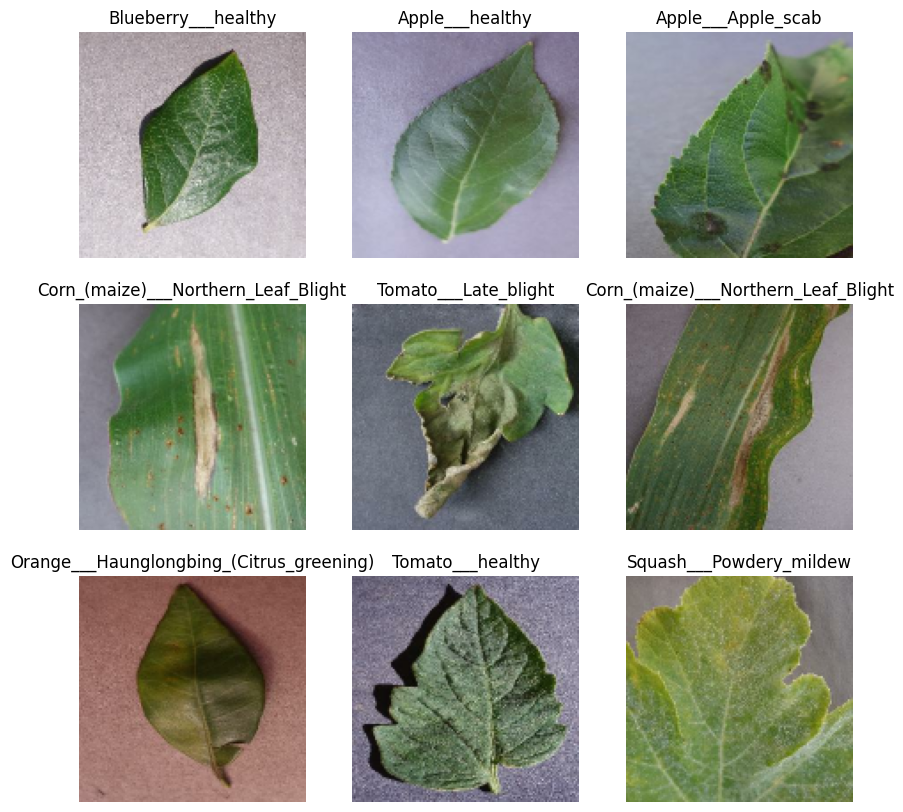

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Optimizing the dataset performance**

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

**Clear Memory Before Model Training**

In [8]:
import gc

gc.collect()
tf.keras.backend.clear_session()


**Building a CNN Model (Without Data Augmentation)**

In [9]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,125,766 (8.11 MB)

 Trainable params: 2,125,766 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

**Training the Model**

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.3347 - loss: 2.6017 - val_accuracy: 0.6595 - val_loss: 1.2162
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6868 - loss: 1.0414 - val_accuracy: 0.7510 - val_loss: 0.8489
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8022 - loss: 0.6383 - val_accuracy: 0.7930 - val_loss: 0.7215
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8760 - loss: 0.3768 - val_accuracy: 0.8005 - val_loss: 0.7334
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9152 - loss: 0.2503 - val_accuracy: 0.7895 - val_loss: 0.8451
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9375 - loss: 0.1917 - val_accuracy: 0.7810 - val_loss: 1.0179
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9553 - loss: 0.1376 - val_accuracy: 0.7405 - val_loss: 1.3429
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9708 - loss: 0.0930 - val_acc

**Plotting the Accuracy & Loss**

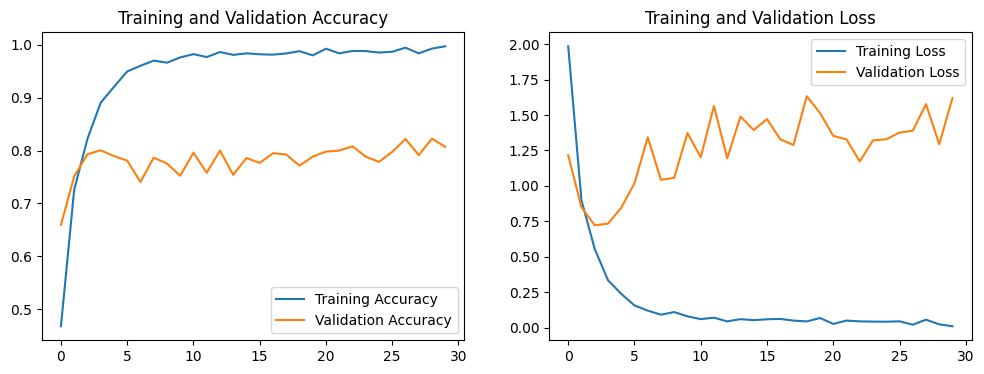

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(30)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

**Evaluating the Model**

In [12]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7993 - loss: 1.7382
Validation Accuracy: 80.80%


**Predicting on New Images from Validation DataSet**

In [13]:
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


**Clear Session Before Building a New Model**

In [14]:
import gc

gc.collect()
tf.keras.backend.clear_session()

**Building a ResNet50 Model**

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load ResNet50 base
resnet_base = ResNet50(
    input_shape=(128, 128, 3),
    include_top=False,   # We will add our own classifier
    weights='imagenet'   # Use pretrained ImageNet weights
)

# Freeze the base model
resnet_base.trainable = False

# Build the full model
resnet_model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile
resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,854,886 (91.00 MB)

 Trainable params: 267,174 (1.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Training the Model**

In [16]:
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.6452 - loss: 1.3936 - val_accuracy: 0.8700 - val_loss: 0.4257
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.9049 - loss: 0.2897 - val_accuracy: 0.8935 - val_loss: 0.3556
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9492 - loss: 0.1618 - val_accuracy: 0.9050 - val_loss: 0.3366
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9662 - loss: 0.0978 - val_accuracy: 0.9010 - val_loss: 0.3082
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9810 - loss: 0.0665 - val_accuracy: 0.9325 - val_loss: 0.2669
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9842 - loss: 0.0495 - val_accuracy: 0.9190 - val_loss: 0.3082
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9862 - loss: 0.0447 - val_accuracy: 0.8975 - val_loss: 0.4199
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9757 - loss: 0.0742 - 

**Plot Accuracy and Loss for the Model**

In [17]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (ResNet50)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (ResNet50)')

plt.show()


**Evaluate the ResNet50 Model**

In [18]:
loss, accuracy = resnet_model.evaluate(val_ds)
print(f"Validation Accuracy (ResNet50): {accuracy * 100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9157 - loss: 0.4117
Validation Accuracy (ResNet50): 91.50%


**Predicting on New Images**

In [19]:
for images, labels in val_ds.take(1):
    predictions = resnet_model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
        plt.axis("off")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


**Clear Session before Building a New Model**

In [20]:
import gc

gc.collect()
tf.keras.backend.clear_session()

**Building a MobileNetV2 Model**

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load MobileNetV2 base
mobilenet_base = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,    # We will add our own custom classifier
    weights='imagenet'    # Pretrained weights
)

# Freeze the base model
mobilenet_base.trainable = False

# Build full model
mobilenet_model = models.Sequential([
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile
mobilenet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Training the Model**

In [22]:
history_mobilenet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.3457 - loss: 2.5565 - val_accuracy: 0.5365 - val_loss: 1.6795
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.5834 - loss: 1.4888 - val_accuracy: 0.5955 - val_loss: 1.4090
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6649 - loss: 1.1750 - val_accuracy: 0.6270 - val_loss: 1.2670
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6883 - loss: 1.0294 - val_accuracy: 0.6640 - val_loss: 1.1478
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7332 - loss: 0.8966 - val_accuracy: 0.6780 - val_loss: 1.0918
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7514 - loss: 0.8160 - val_accuracy: 0.6815 - val_loss: 1.0901
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7795 - loss: 0.7342 - val_accuracy: 0.6855 - val_loss: 1.0745
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7936 - loss: 0.6774 - val_ac

**Plotting Accuracy and Loss for the Model**

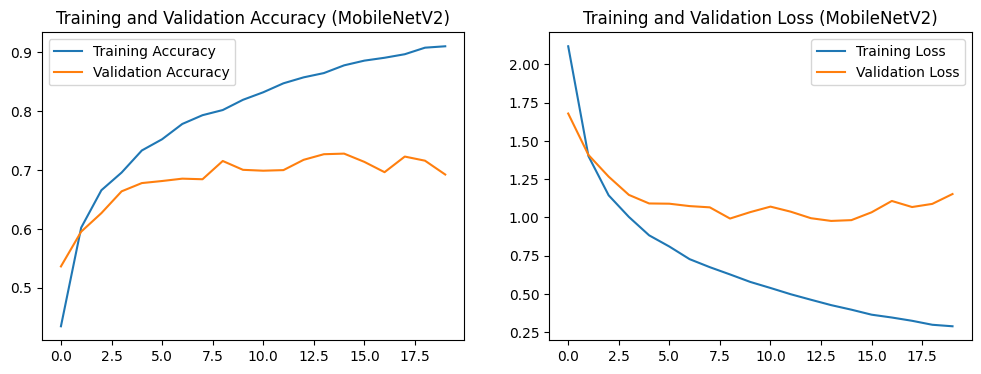

In [23]:
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (MobileNetV2)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (MobileNetV2)')

plt.show()

**Evaluating the Model**

In [24]:
loss, accuracy = mobilenet_model.evaluate(val_ds)
print(f"Validation Accuracy (MobileNetV2): {accuracy * 100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6908 - loss: 1.1518
Validation Accuracy (MobileNetV2): 69.35%


**Predicting on New Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


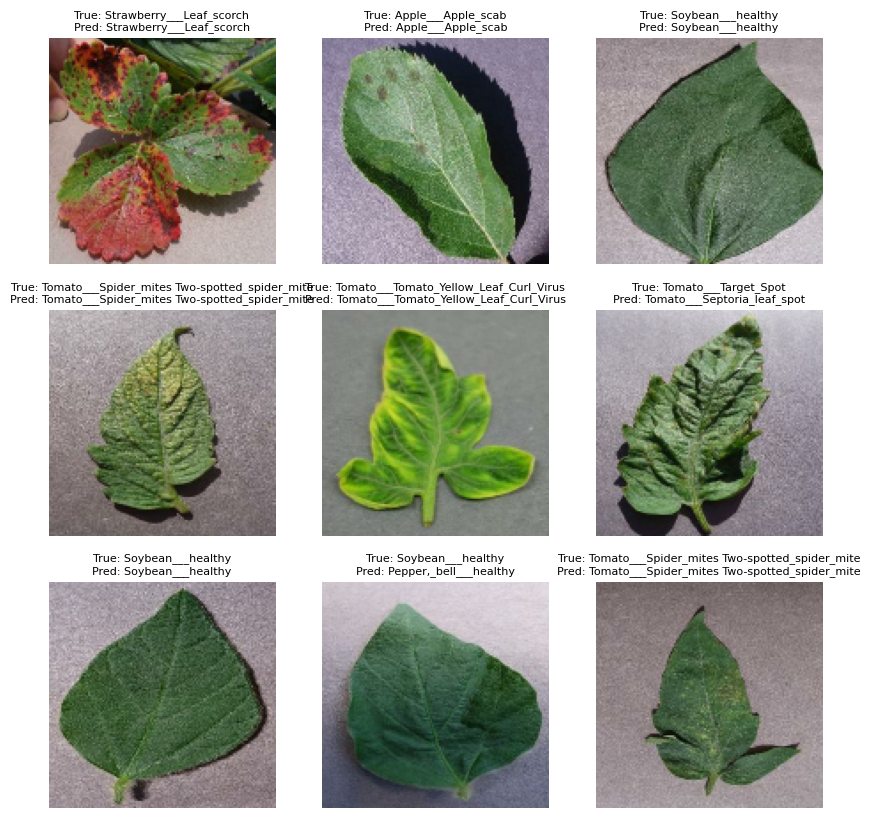

In [25]:
for images, labels in val_ds.take(1):
    predictions = mobilenet_model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
        plt.axis("off")

**Visualizing a Comparison between all 3 Models (Simple CNN, ResNet50, and MobileNetV2)**

In [26]:
import matplotlib.pyplot as plt

# Prepare epochs ranges
epochs_cnn = range(len(history.history['accuracy']))
epochs_resnet = range(len(history_resnet.history['accuracy']))
epochs_mobilenet = range(len(history_mobilenet.history['accuracy']))

# Plot Training Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_cnn, history.history['accuracy'], label='Simple CNN - Train')
plt.plot(epochs_cnn, history.history['val_accuracy'], label='Simple CNN - Val')
plt.plot(epochs_resnet, history_resnet.history['accuracy'], label='ResNet50 - Train')
plt.plot(epochs_resnet, history_resnet.history['val_accuracy'], label='ResNet50 - Val')
plt.plot(epochs_mobilenet, history_mobilenet.history['accuracy'], label='MobileNetV2 - Train')
plt.plot(epochs_mobilenet, history_mobilenet.history['val_accuracy'], label='MobileNetV2 - Val')

plt.legend()
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_cnn, history.history['loss'], label='Simple CNN - Train')
plt.plot(epochs_cnn, history.history['val_loss'], label='Simple CNN - Val')
plt.plot(epochs_resnet, history_resnet.history['loss'], label='ResNet50 - Train')
plt.plot(epochs_resnet, history_resnet.history['val_loss'], label='ResNet50 - Val')
plt.plot(epochs_mobilenet, history_mobilenet.history['loss'], label='MobileNetV2 - Train')
plt.plot(epochs_mobilenet, history_mobilenet.history['val_loss'], label='MobileNetV2 - Val')

plt.legend()
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


**TRAINING THE SAME MODELS WITH DATA AUGMENTATION**

In [27]:
import gc
gc.collect()
tf.keras.backend.clear_session()

**Simple CNN (With Data Augmentation)**

In [28]:
cnn_aug_model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

cnn_aug_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_aug_model.summary()

history_cnn_aug = cnn_aug_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.2512 - loss: 2.8592 - val_accuracy: 0.5010 - val_loss: 1.8000
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5213 - loss: 1.6715 - val_accuracy: 0.5905 - val_loss: 1.4075
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6275 - loss: 1.2408 - val_accuracy: 0.6590 - val_loss: 1.1322
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6823 - loss: 1.0606 - val_accuracy: 0.7090 - val_loss: 0.9593
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7272 - loss: 0.8969 - val_accuracy: 0.7385 - val_loss: 0.8552
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7535 - loss: 0.8044 - val_accuracy: 0.7590 - val_loss: 0.7669
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7700 - loss: 0.7272 - val_accuracy: 0.7735 - val_loss: 0.7429
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7957 - loss: 0.6374 - val_acc

**Simple CNN Visualization (Augmented)**

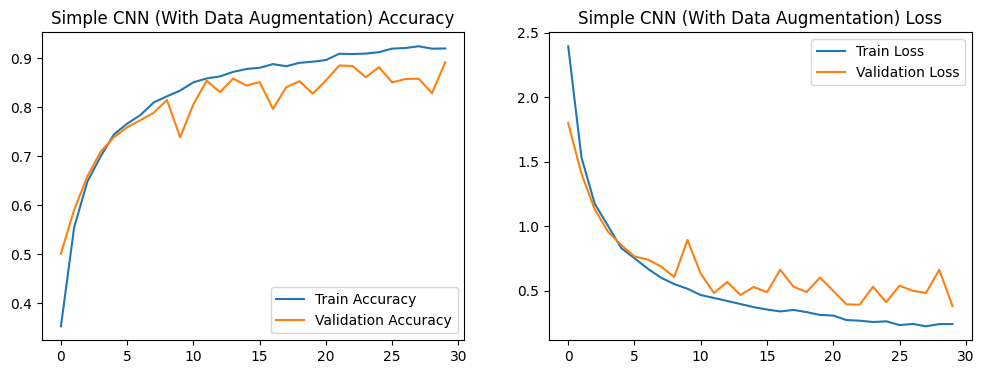

In [29]:
epochs_cnn_aug = range(len(history_cnn_aug.history['accuracy']))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_cnn_aug, history_cnn_aug.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_cnn_aug, history_cnn_aug.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Simple CNN (With Data Augmentation) Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_cnn_aug, history_cnn_aug.history['loss'], label='Train Loss')
plt.plot(epochs_cnn_aug, history_cnn_aug.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Simple CNN (With Data Augmentation) Loss')

plt.show()


**ResNet50 (With Data Augmentation)**

In [30]:
gc.collect()
tf.keras.backend.clear_session()

resnet_aug_model = models.Sequential([
    data_augmentation,
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

resnet_aug_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

resnet_aug_model.summary()

history_resnet_aug = resnet_aug_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,854,886 (91.00 MB)

 Trainable params: 267,174 (1.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.5806 - loss: 1.5815 - val_accuracy: 0.7985 - val_loss: 0.6645
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.8440 - loss: 0.4762 - val_accuracy: 0.8360 - val_loss: 0.5512
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.8736 - loss: 0.3855 - val_accuracy: 0.8260 - val_loss: 0.5713
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.8957 - loss: 0.3082 - val_accuracy: 0.8535 - val_loss: 0.4681
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9041 - loss: 0.2914 - val_accuracy: 0.8625 - val_loss: 0.4738
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.9156 - loss: 0.2549 - val_accuracy: 0.8645 - val_loss: 0.4454
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.9089 - loss: 0.2680 - val_accuracy: 0.8735 - val_loss: 0.4669
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9235 - loss: 0.2278 - 

**ResNet50 Visualization (Augmented)**

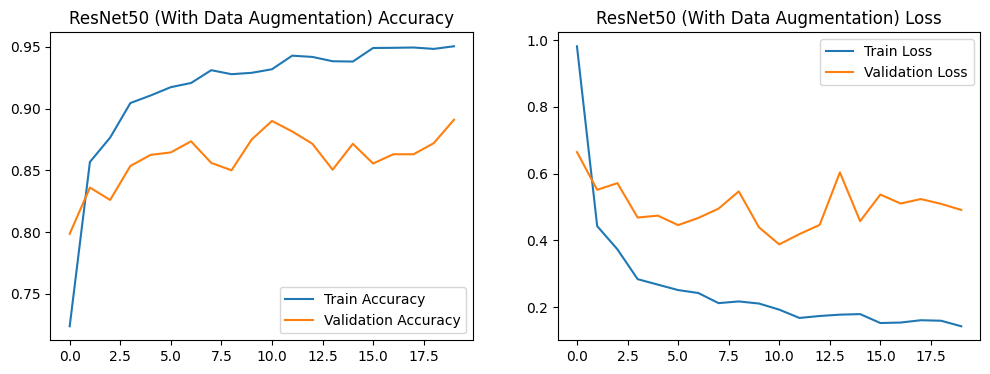

In [31]:
# Plotting ResNet50 (Augmented) alone
epochs_resnet_aug = range(len(history_resnet_aug.history['accuracy']))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_resnet_aug, history_resnet_aug.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_resnet_aug, history_resnet_aug.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('ResNet50 (With Data Augmentation) Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_resnet_aug, history_resnet_aug.history['loss'], label='Train Loss')
plt.plot(epochs_resnet_aug, history_resnet_aug.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('ResNet50 (With Data Augmentation) Loss')

plt.show()

**MobileNetV2 (With Data Augmentation)**

In [32]:
gc.collect()
tf.keras.backend.clear_session()

mobilenet_aug_model = models.Sequential([
    data_augmentation,
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

mobilenet_aug_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_aug_model.summary()

history_mobilenet_aug = mobilenet_aug_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.3199 - loss: 2.6363 - val_accuracy: 0.4360 - val_loss: 1.9842
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.4974 - loss: 1.7932 - val_accuracy: 0.4900 - val_loss: 1.8051
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5531 - loss: 1.5815 - val_accuracy: 0.5055 - val_loss: 1.7216
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.5868 - loss: 1.4451 - val_accuracy: 0.4490 - val_loss: 1.9119
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6002 - loss: 1.3761 - val_accuracy: 0.5180 - val_loss: 1.6751
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6049 - loss: 1.3078 - val_accuracy: 0.5270 - val_loss: 1.6509
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6248 - loss: 1.2736 - val_accuracy: 0.5325 - val_loss: 1.6540
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6334 - loss: 1.2248 - 

**MobileNetV2 Visualization (Augmented)**

In [33]:
# Plotting MobileNetV2 (Augmented) alone
epochs_mobilenet_aug = range(len(history_mobilenet_aug.history['accuracy']))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_mobilenet_aug, history_mobilenet_aug.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_mobilenet_aug, history_mobilenet_aug.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('MobileNetV2 (With Data Augmentation) Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_mobilenet_aug, history_mobilenet_aug.history['loss'], label='Train Loss')
plt.plot(epochs_mobilenet_aug, history_mobilenet_aug.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('MobileNetV2 (With Data Augmentation) Loss')

plt.show()


**Final Visualization Comparing all the Augmented Models (Simple CNN, ResNet50, and MobileNetV2)**

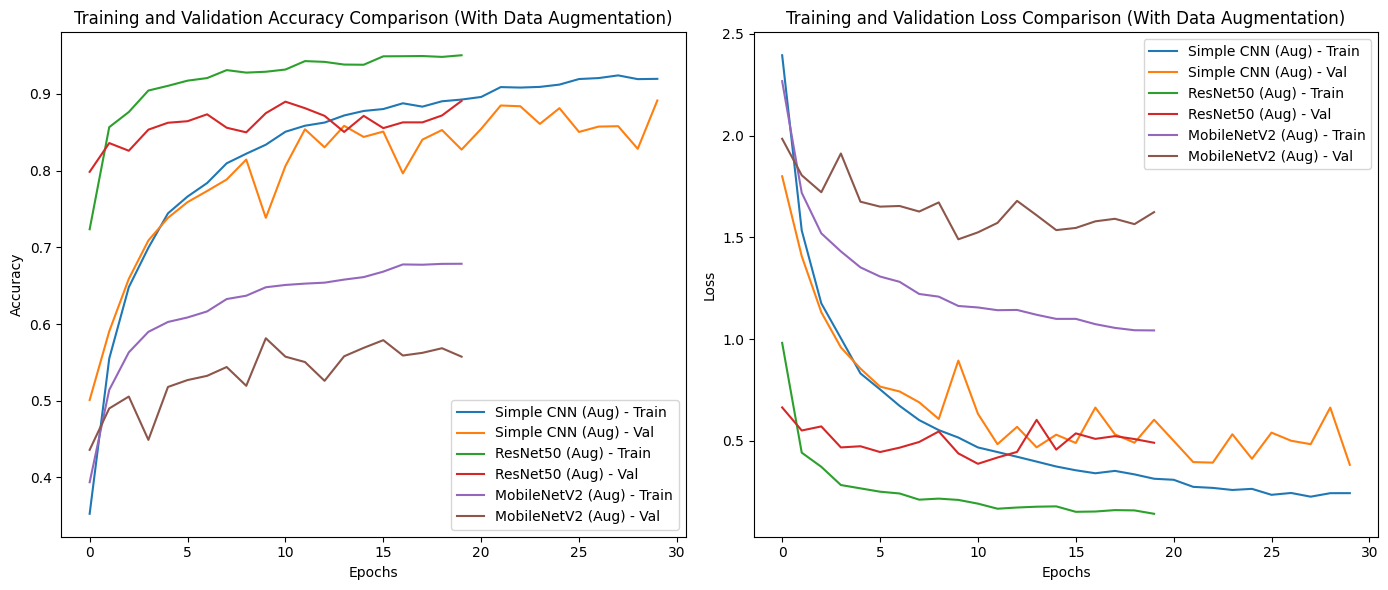

In [34]:
# Prepare epochs ranges
epochs_cnn_aug = range(len(history_cnn_aug.history['accuracy']))
epochs_resnet_aug = range(len(history_resnet_aug.history['accuracy']))
epochs_mobilenet_aug = range(len(history_mobilenet_aug.history['accuracy']))

# Plot Training Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_cnn_aug, history_cnn_aug.history['accuracy'], label='Simple CNN (Aug) - Train')
plt.plot(epochs_cnn_aug, history_cnn_aug.history['val_accuracy'], label='Simple CNN (Aug) - Val')
plt.plot(epochs_resnet_aug, history_resnet_aug.history['accuracy'], label='ResNet50 (Aug) - Train')
plt.plot(epochs_resnet_aug, history_resnet_aug.history['val_accuracy'], label='ResNet50 (Aug) - Val')
plt.plot(epochs_mobilenet_aug, history_mobilenet_aug.history['accuracy'], label='MobileNetV2 (Aug) - Train')
plt.plot(epochs_mobilenet_aug, history_mobilenet_aug.history['val_accuracy'], label='MobileNetV2 (Aug) - Val')

plt.legend()
plt.title('Training and Validation Accuracy Comparison (With Data Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_cnn_aug, history_cnn_aug.history['loss'], label='Simple CNN (Aug) - Train')
plt.plot(epochs_cnn_aug, history_cnn_aug.history['val_loss'], label='Simple CNN (Aug) - Val')
plt.plot(epochs_resnet_aug, history_resnet_aug.history['loss'], label='ResNet50 (Aug) - Train')
plt.plot(epochs_resnet_aug, history_resnet_aug.history['val_loss'], label='ResNet50 (Aug) - Val')
plt.plot(epochs_mobilenet_aug, history_mobilenet_aug.history['loss'], label='MobileNetV2 (Aug) - Train')
plt.plot(epochs_mobilenet_aug, history_mobilenet_aug.history['val_loss'], label='MobileNetV2 (Aug) - Val')

plt.legend()
plt.title('Training and Validation Loss Comparison (With Data Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


**Visualization for the Presentation**

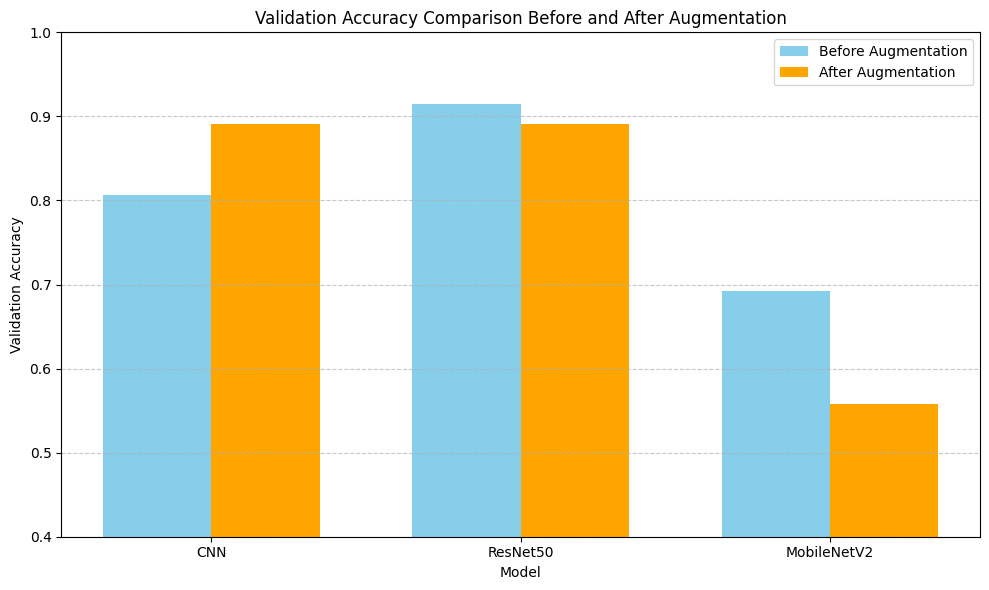

In [35]:
import matplotlib.pyplot as plt

# Extract final validation accuracy from each model
val_acc_cnn = history.history['val_accuracy'][-1]
val_acc_resnet = history_resnet.history['val_accuracy'][-1]
val_acc_mobilenet = history_mobilenet.history['val_accuracy'][-1]

val_acc_cnn_aug = history_cnn_aug.history['val_accuracy'][-1]
val_acc_resnet_aug = history_resnet_aug.history['val_accuracy'][-1]
val_acc_mobilenet_aug = history_mobilenet_aug.history['val_accuracy'][-1]

# Data for the bar chart
models = ['CNN', 'ResNet50', 'MobileNetV2']
before_aug = [val_acc_cnn, val_acc_resnet, val_acc_mobilenet]
after_aug = [val_acc_cnn_aug, val_acc_resnet_aug, val_acc_mobilenet_aug]

# Plotting
x = range(len(models))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, before_aug, width=bar_width, label='Before Augmentation', color='skyblue')
plt.bar([p + bar_width for p in x], after_aug, width=bar_width, label='After Augmentation', color='orange')

plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison Before and After Augmentation')
plt.xticks([p + bar_width / 2 for p in x], models)
plt.ylim(0.4, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
